14-1 들어가며 <br>
14-2 내부 모듈 구현하기 <br>
14-3 모듈 조합하기 <br>
14-4 모델 밖의 조력자들 <br>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


1. 입력 데이터 → [ batch_size x length ] <br>
2. Source & Target Embedding → [ batch_size x length x d_emb ] <br>
3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다. <br>
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다. <br>
    1. Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ] <br>
    2. Masking for Masked Attention <br>
    3. Scaled Dot Product Attention <br>
    4. Combine Heads →[ batch_size x length x d_emb ] <br>
5. Residual Connection <br>
6. Layer Normalization <br>
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ] <br>
8. Output Linear Layer → [ batch_size x length x vocab_size ] <br>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


<b> Multi-Head Attention </b> <br>
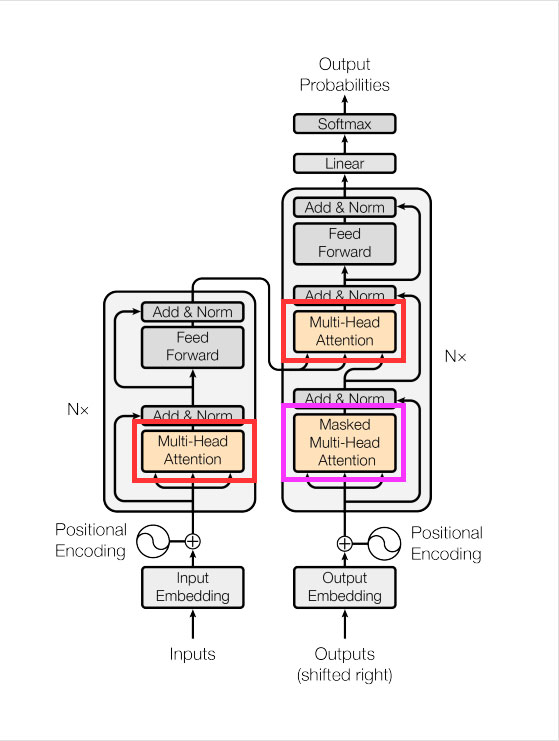 <br>
Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성된다. Embedding된 입력을 <b>Head수로 분할</b> split_heads(), 분할된 입력으로부터 <b>Attention 값을 구하는</b> scaled_dot_product_attention(), 연산이 종료되고 분할된 <b>Head를 다시 하나로 결합</b> 시켜주는 combine_heads()까지 MultiHeadAttention 클래스를 정의하여 모두 포함시켜줄 것이다! <br>

Masking부분은, 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의되야 된다. 

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
        

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b = True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None: scaled_qk += (mask * -1e9)
    
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        
        return out, attentions

        

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])
        
        return split_x
        


    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.trasnpose(x, perm=[0,2,13])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    
    def call(self, Q, K, V, mask):
        
        # Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        # Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split) -> out, attention_weights
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # Step 4: Combine Heads(out) -> out
        self.combine_hedas(out)
        
        # Step 5: Linear_out(out) -> out
        self.linear(out)

        return out, attention_weights

print("슝=3")

슝=3


<b> Position-wise Feed-Forward Network </b> <br>
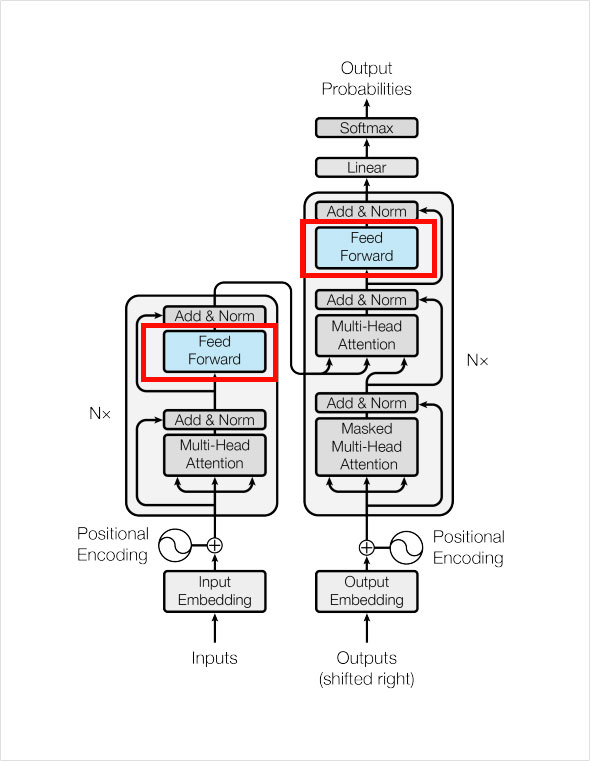 <br>

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### 14-3 모듈 조립하기

트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있다! <br>
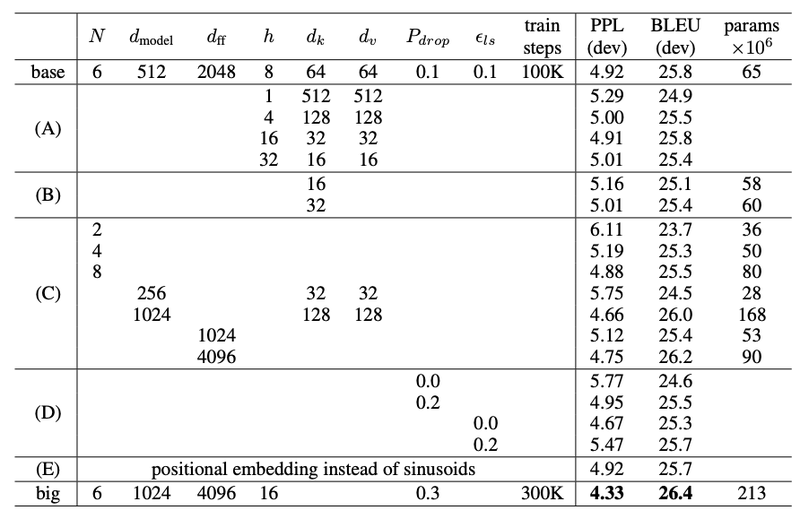 <br>
레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성해 볼 수 있겠다. <br>
마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 된다. 여러분은 이미 Layer 클래스를 정의해 본 적이 있는데, 바로 직전의 MultiHeadAttention 이 그렇게 정의된 레이어다. 이 방법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있다. <br>

<b>Encdoer 레이어 구현하기</b>

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했다.


<b> Decoder 레이어 구현하기 </b>

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(Decoderlayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        
        '''
        Masked Multi-Head Attention 
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        '''
        Multi-Head Attention
        '''
        residual = out 
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual 
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


<b> Transformer 완성하기 </b>

Encoder와 Decoder를 가지고 최종적으로 트랜스포머를 완성한다.
1. shared 변수를 매개변수로 받아 True일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게 하자. Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는것 잊지말기(참고: tf.keras.layers.Layer.set_weights()) <br>
2. 우리가 정의한 positional_encoding의 반환값 형태는 [Length x d_model]인데, 이를 더해줄 Embedding 값 형태가 [Batch x Length x d_model]이라서 연산이 불가능하다. 연산이 가능하도록 수정하자. (참고: tf.expand_dims(), np.newaxis)

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.lysers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        # 6. Dropout 정의
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
                
        if self.shared: out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)
        
        return out 

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
       
        #Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### 14-4 모델 밖의 조력자들

Transformer의 learning rate도 일반적이지 않다. 모델 외적인 부분을 정의해 주도록 하겠다. 

In [ ]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

각 배치 별로 <b>데이터의 꼬리 부분을 Masking</b> 하는 형태임을 알 수 있다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데 이것이 바로 <b>Causality Mask와 Padding Mask를 결합한 형태</b>이다. 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 <b>인과 관계 마스킹</b>을 했었다. 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된다! <br><br>
    
    
트랜스포머는 고정된 Learning Rate를 사용하지 않았었다. 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴보자. 이전 노드에서 Learning Rate를 numpy로 간단히 구현을 했었는데, 이번엔 <b>Tensorflow 상에서 잘 구동될 수 있도록</b> LearningRateSchedule 클래스를 상속받아 구현할 것이다.

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")